In [26]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime

In [27]:
orders = pd.read_csv('orders.csv')
sales = pd.read_csv('sales.csv')
user = pd.read_csv('user.csv')
store = pd.read_csv('store.csv')
product = pd.read_csv('product.csv')

orders

,order_id,order_date,user_id,store_id,product_info
0,1,2022-01-11,13,6,"[{'product_id': 3283, 'product_price': 18245.9..."
1,2,2022-01-11,70,6,"[{'product_id': 505, 'product_price': 11060.84..."
2,3,2022-01-11,75,6,"[{'product_id': 1546, 'product_price': 3065.23..."
3,4,2022-01-11,172,6,"[{'product_id': 3354, 'product_price': 7131.35..."
4,5,2022-01-11,176,6,"[{'product_id': 3595, 'product_price': 13762.1..."
...,...,...,...,...,...
1009995,1009996,2023-11-30,9966,15,"[{'product_id': 138, 'product_price': 9948.590..."
1009996,1009997,2023-11-30,9978,15,"[{'product_id': 1389, 'product_price': 8984.21..."
1009997,1009998,2023-11-30,9979,15,"[{'product_id': 2341, 'product_price': 18336.8..."
1009998,1009999,2023-11-30,9984,15,"[{'product_id': 710, 'product_price': 9029.154..."


In [28]:
query = """WITH corrected_orders AS
(SELECT
    order_id,
    order_date,
    user_id,
    store_id,
    replace(replace(replace(replace(replace(product_info, '''', '"'), 'product_comission', 'product_commission'), 'comission_is_percent', 'commission_is_percent'), 'True', 'true'), 'False', 'false') as product_info
FROM orders)
SELECT
    o.order_id,
    o.order_date,
    o.user_id,
    o.store_id,
    json_extract(value, '$.product_id') AS product_id,
    json_extract(value, '$.product_price') AS product_price,
    json_extract(value, '$.product_commission') AS product_commission,
    json_extract(value, '$.commission_is_percent') AS commission_is_percent,
    json_extract(value, '$.count') AS count
FROM corrected_orders o,
json_each(o.product_info)
WHERE json_valid(o.product_info)"""
orders = sqldf(query, globals())
orders.head()

,order_id,order_date,user_id,store_id,product_id,product_price,product_commission,commission_is_percent,count
0,1,2022-01-11,13,6,3283,18245.907938,3000,0,1
1,1,2022-01-11,13,6,1068,22866.089754,75,1,1
2,2,2022-01-11,70,6,505,11060.841781,5,1,1
3,2,2022-01-11,70,6,1351,20084.282173,7500,0,1
4,2,2022-01-11,70,6,94,16995.189349,5,1,1


In [29]:
orders['order_date'] = pd.to_datetime(orders['order_date'])
sales['purchase_date'] = pd.to_datetime(sales['purchase_date'])

In [30]:
total_sales = sales[sales['is_accepted'] & ~sales['is_canceled']]['purchase_date'].count()
total_orders = orders['order_id'].nunique()
avg_order_value = orders.groupby('order_id')['product_price'].sum().mean()
avg_commission = orders.apply(lambda x: x['product_commission'] * x['product_price'] / 100 if x['commission_is_percent'] else x['product_commission'], axis=1).mean()
unique_users = user['user_id'].nunique()

print(f"Общая сумма продаж: {total_sales}")
print(f"Количество уникальных заказов: {total_orders}")
print(f"Средняя стоимость заказа: {avg_order_value:.2f}")
print(f"Средняя комиссия компании с заказа: {avg_commission:.2f}")
print(f"Количество уникальных пользователей: {unique_users}")

Общая сумма продаж: 1411786
Количество уникальных заказов: 1010000
Средняя стоимость заказа: 45933.47
Средняя комиссия компании с заказа: 4601.88
Количество уникальных пользователей: 10000


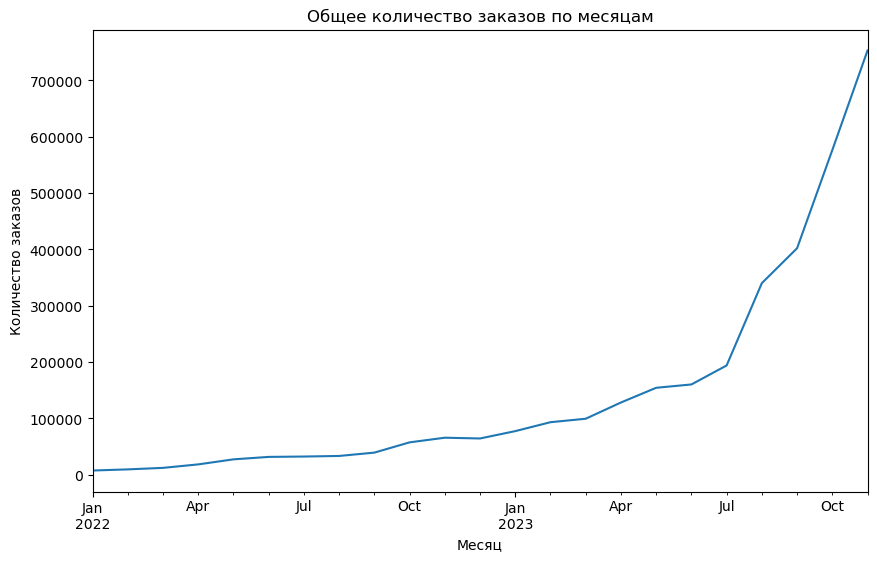

In [7]:
orders['month'] = orders['order_date'].dt.to_period('M')
monthly_orders = orders.groupby('month').size()

plt.figure(figsize=(10, 6))
monthly_orders.plot(kind='line')
plt.title('Общее количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

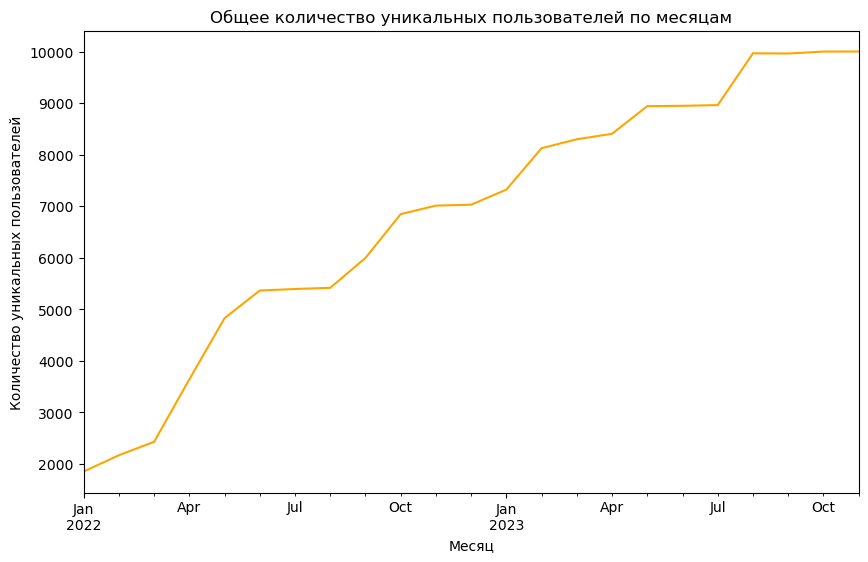

In [8]:
monthly_unique_users = orders.groupby('month')['user_id'].nunique()

plt.figure(figsize=(10, 6))
monthly_unique_users.plot(kind='line', color='orange')
plt.title('Общее количество уникальных пользователей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных пользователей')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


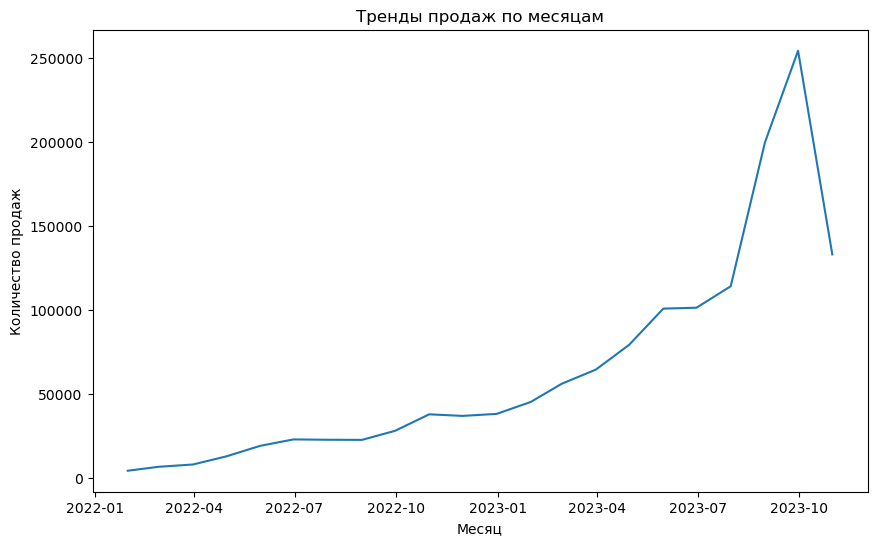

In [9]:
sales['purchase_date'] = pd.to_datetime(sales['purchase_date'])
monthly_sales = sales[(sales['is_accepted']) & (~sales['is_canceled'])].set_index('purchase_date').resample('M').size()
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales)
plt.title('Тренды продаж по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество продаж')
plt.show()

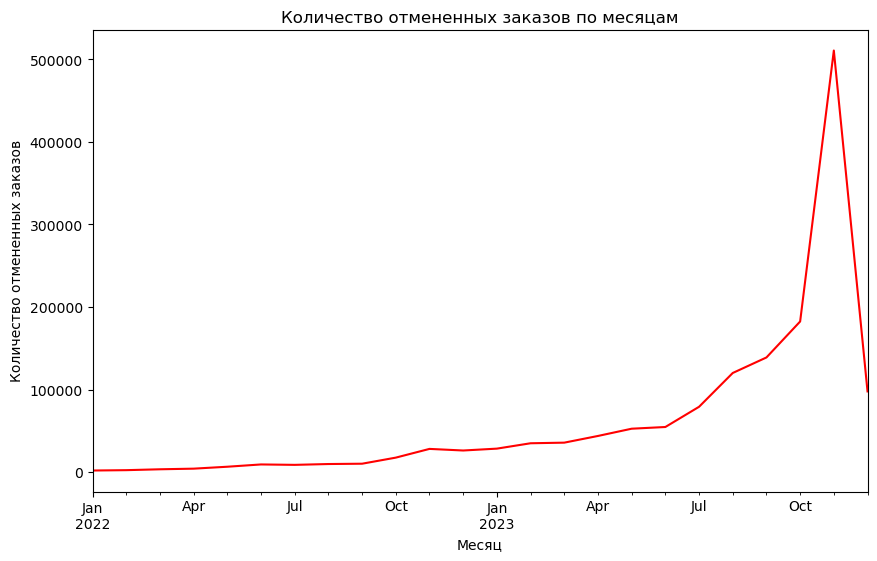

In [10]:
sales['month'] = sales['purchase_date'].dt.to_period('M')
monthly_canceled_orders = sales[sales['is_canceled']].groupby('month').size()

plt.figure(figsize=(10, 6))
monthly_canceled_orders.plot(kind='line', color='red')
plt.title('Количество отмененных заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество отмененных заказов')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


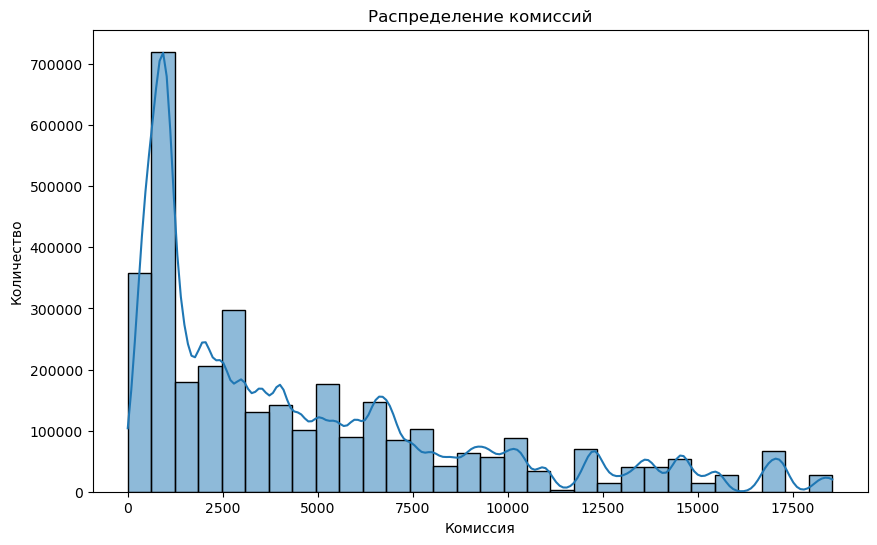

In [13]:
orders['commission_value'] = orders.apply(lambda x: x['product_commission'] * x['product_price'] / 100 if x['commission_is_percent'] else x['product_commission'], axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(orders['commission_value'], bins=30, kde=True)
plt.title('Распределение комиссий')
plt.xlabel('Комиссия')
plt.ylabel('Количество')
plt.show()

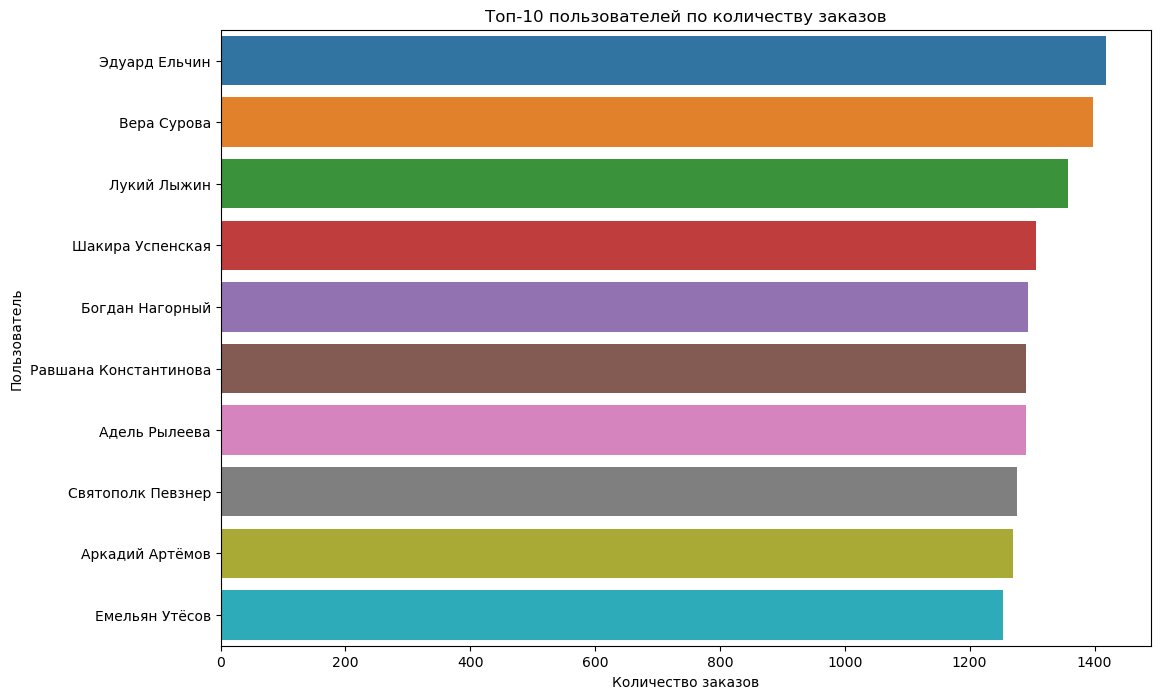

In [15]:
top_users = orders['user_id'].value_counts().head(10).reset_index()
top_users.columns = ['user_id', 'order_count']
top_users = top_users.merge(user, on='user_id')

plt.figure(figsize=(12, 8))
sns.barplot(x='order_count', y='user_name', data=top_users)
plt.title('Топ-10 пользователей по количеству заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Пользователь')
plt.show()

In [31]:
successful_sales = sales[(sales['is_accepted'] == True) & (sales['is_canceled'] == False)]
sales_orders = successful_sales.merge(orders, on=['order_id', 'product_id'], how='left')
sales_orders['purchase_date'] = pd.to_datetime(sales_orders['purchase_date'])
sales_orders['order_date'] = pd.to_datetime(sales_orders['order_date'])

monthly_sales = sales_orders.groupby([sales_orders['purchase_date'].dt.to_period('M'), 'store_id', 'product_id']).agg({'count': 'sum'}).reset_index()
monthly_sales['purchase_date'] = monthly_sales['purchase_date'].dt.to_timestamp()

last_10_months = monthly_sales[monthly_sales['purchase_date'] >= (pd.Timestamp.now() - pd.DateOffset(months=10))]

average_sales = last_10_months.groupby(['store_id', 'product_id']).agg({'count': 'mean'}).reset_index()
average_sales.rename(columns={'count': 'avg_monthly_count'}, inplace=True)

predictions = average_sales.copy()

# Средние значения количества продаж - необходимое количество
predictions['predicted_count'] = predictions['avg_monthly_count'].apply(np.ceil).astype(int)

predictions.drop(columns=['avg_monthly_count'], inplace=True)

predictions.head()

,store_id,product_id,predicted_count
0,1,1,4
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,4


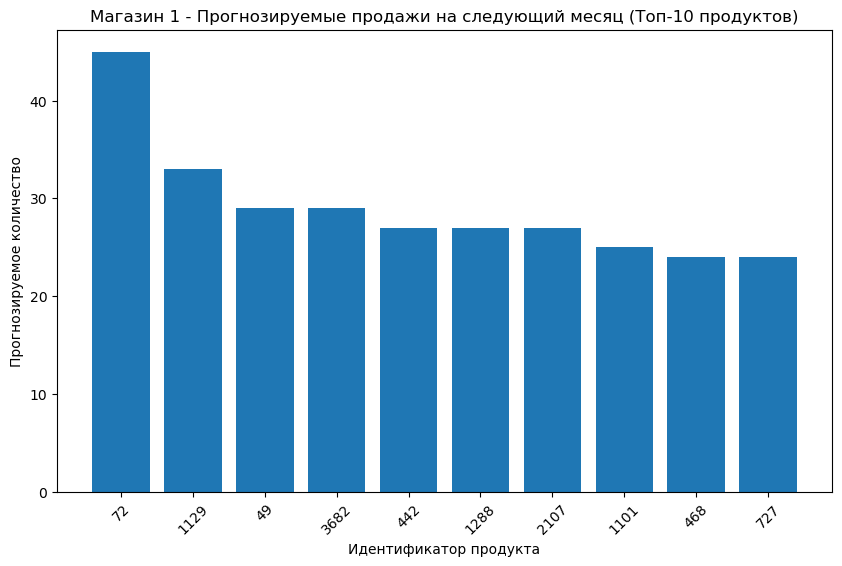

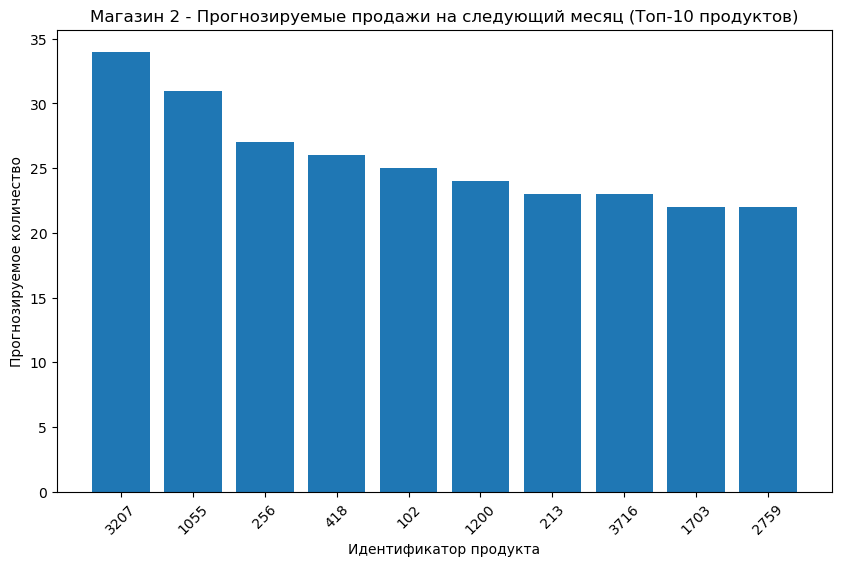

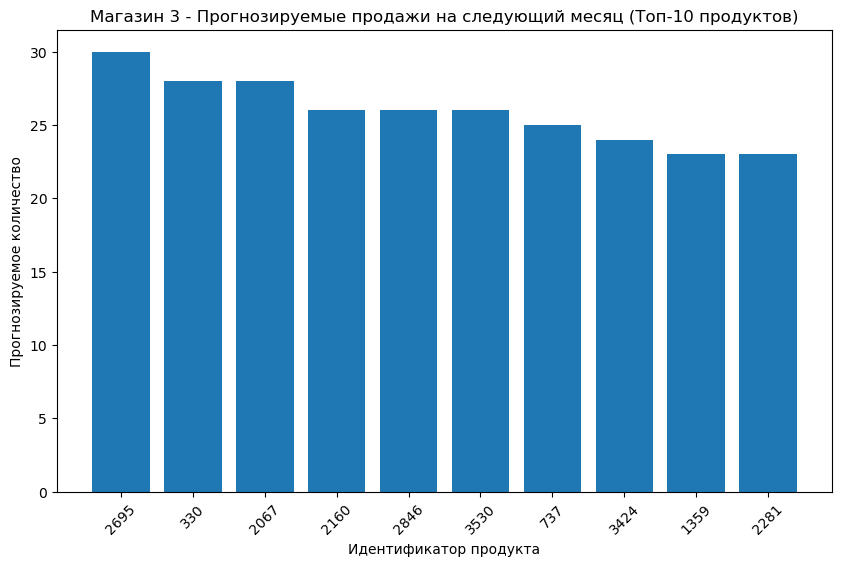

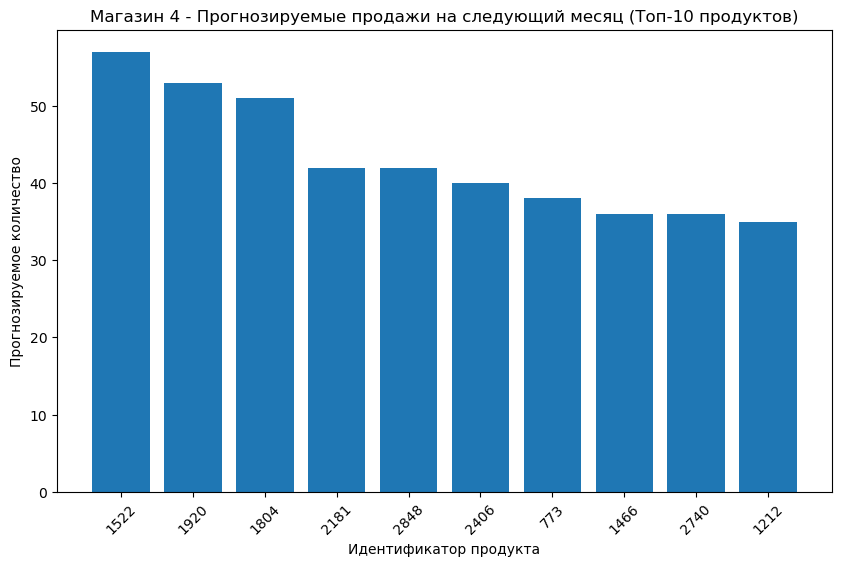

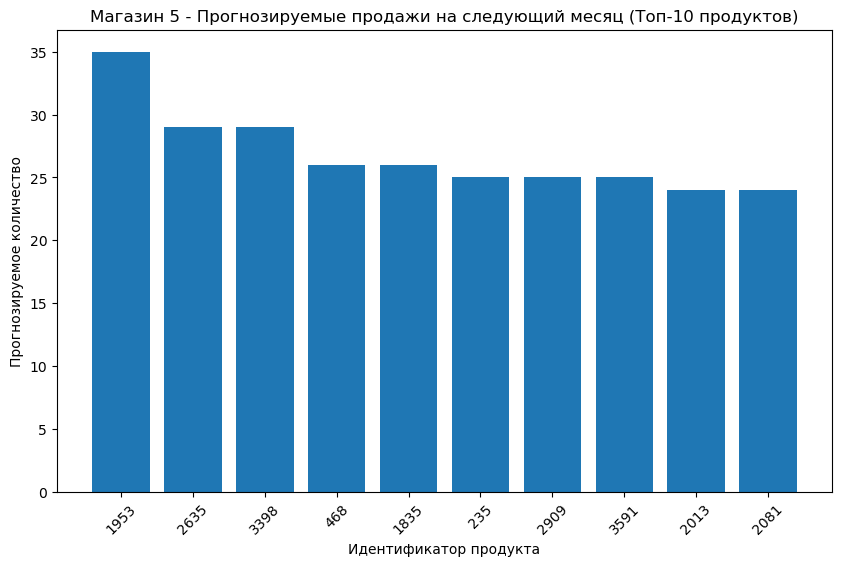

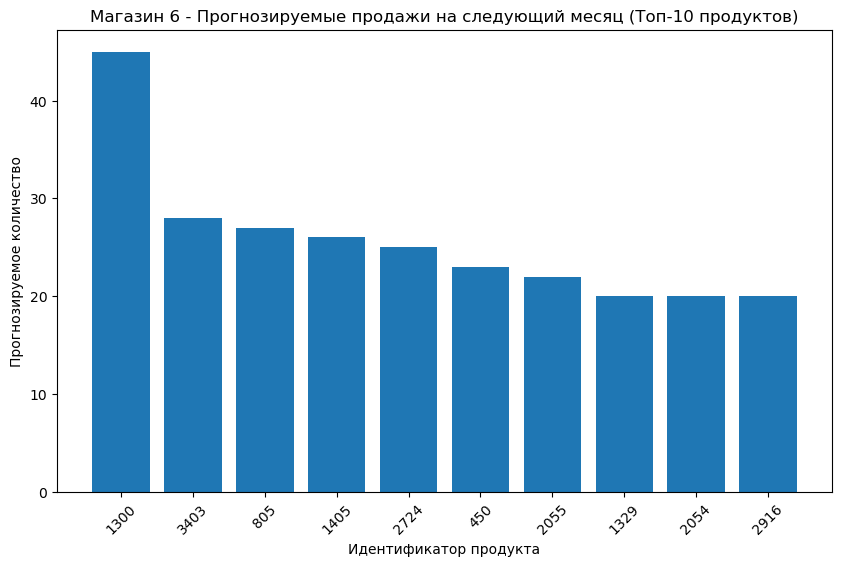

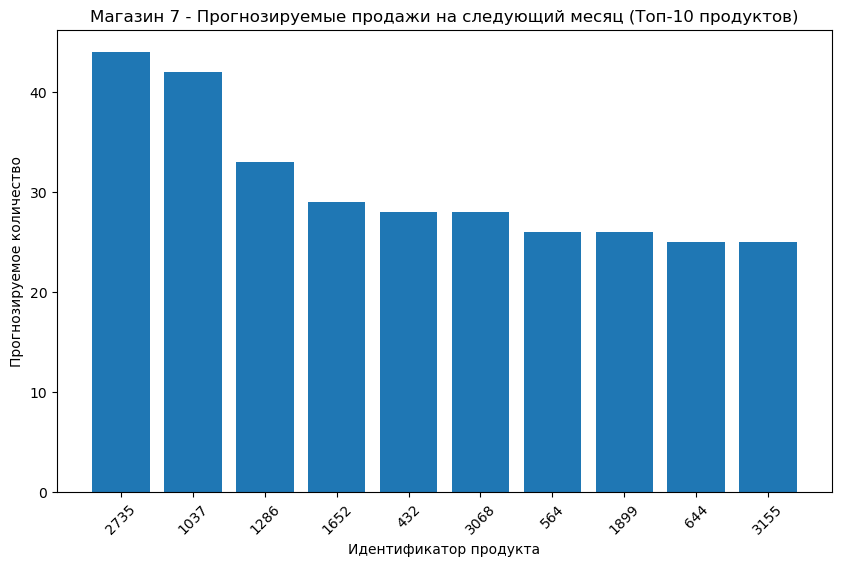

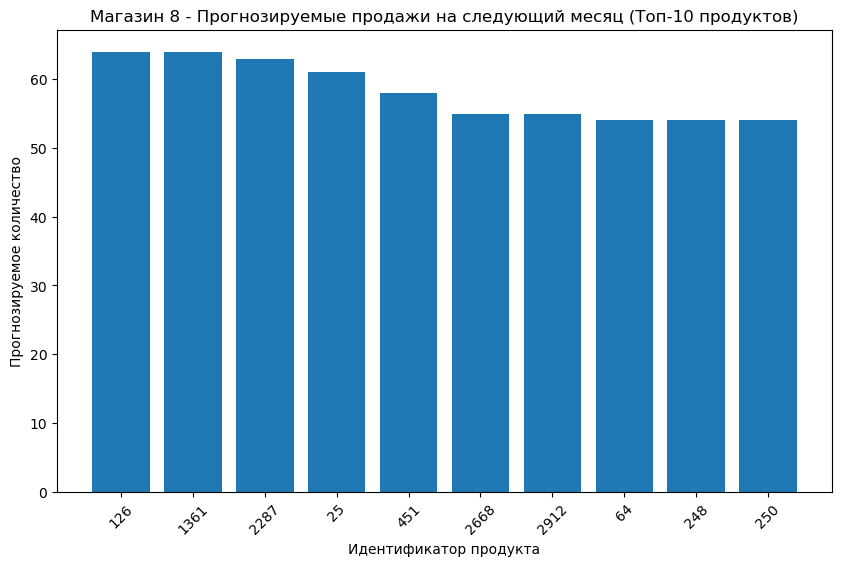

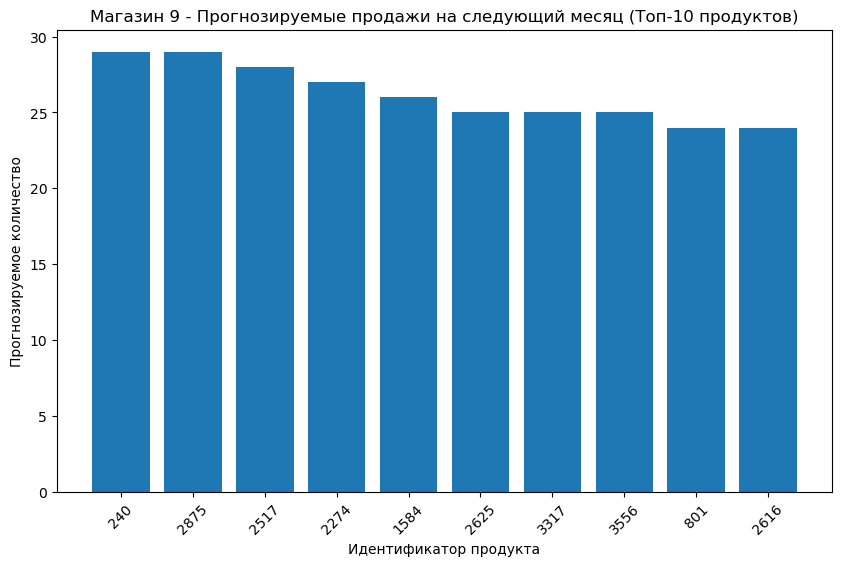

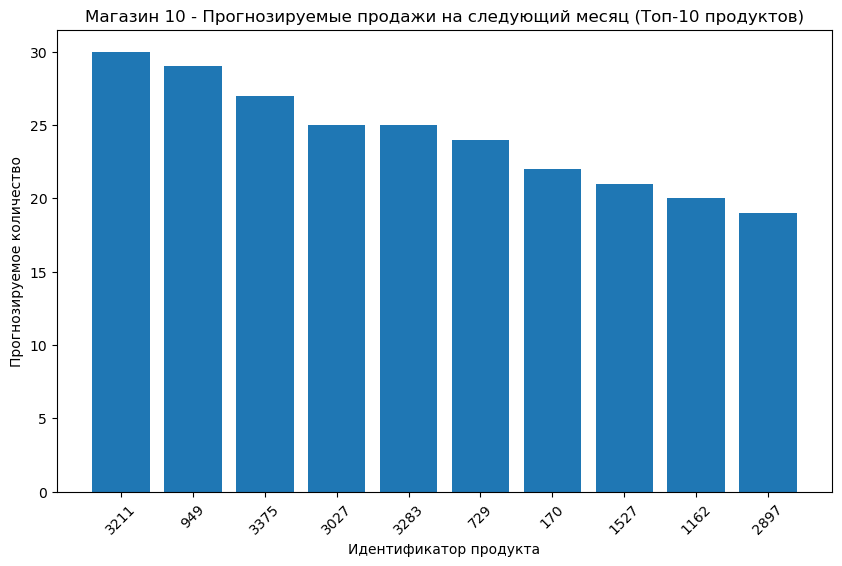

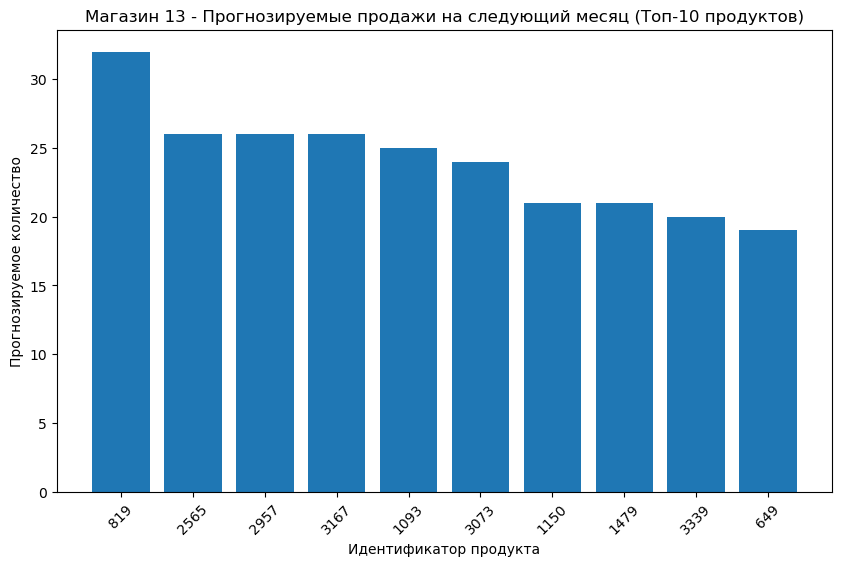

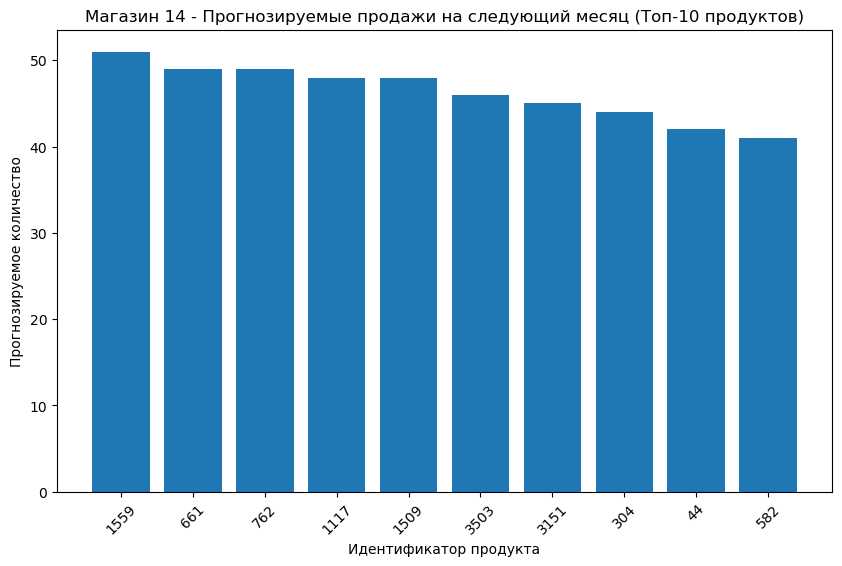

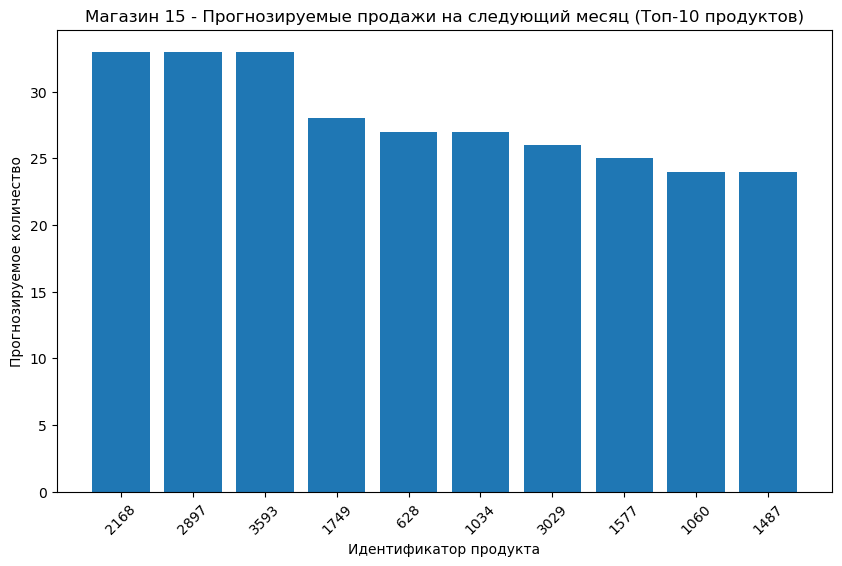

In [32]:
max_products_per_plot = 10

for store_id in predictions['store_id'].unique():
    store_data = predictions[predictions['store_id'] == store_id]
    
    # Выбираем топ-10 продуктов по среднему количеству продаж
    top_products = store_data.nlargest(max_products_per_plot, 'predicted_count')
    
    plt.figure(figsize=(10, 6))
    plt.bar(top_products['product_id'].astype(str), top_products['predicted_count'])
    
    plt.title(f'Магазин {store_id} - Прогнозируемые продажи на следующий месяц (Топ-10 продуктов)')
    plt.xlabel('Идентификатор продукта')
    plt.ylabel('Прогнозируемое количество')
    plt.xticks(rotation=45)
    plt.show()

In [36]:
# Таблица, агрегированная по пользователям и выкупленным заказам 
# (в заказах учитываются только выкупленные товары, по которым не было возврата)
query = """WITH accepted_sales AS (
    SELECT
        order_id,
        product_id
    FROM sales
    WHERE is_accepted = 1 AND is_canceled = 0
),

order_aggregates AS 
(SELECT
        op.user_id,
        op.order_id,
        op.order_date,
        SUM(op.product_price * op.count) AS order_sum,
        SUM(
            CASE
                WHEN op.commission_is_percent = 1 THEN (op.product_price * (op.product_commission / 100.0)) * op.count
                ELSE op.product_commission * op.count
            END
        ) AS order_revenue,
        SUM(op.count) AS order_quantity,
        COUNT(DISTINCT op.product_id) AS order_unique_products
    FROM orders op
    JOIN accepted_sales sa ON op.order_id = sa.order_id AND op.product_id = sa.product_id
    GROUP BY op.user_id, op.order_id, op.order_date)

SELECT
    ua.user_id AS USER_ID,
    ua.order_id AS ORDER_ID,
    ua.order_date AS ORDER_DATE,
    ua.order_sum AS ORDER_SUM,
    ua.order_revenue AS ORDER_REVENUE,
    ua.order_quantity AS ORDER_QUANTITY,
    ua.order_unique_products AS ORDER_UNIQUE_PRODUCTS
FROM order_aggregates ua
ORDER BY ua.user_id, ua.order_date
"""
user_product_orders = sqldf(query, globals())
user_product_orders.head()

,USER_ID,ORDER_ID,ORDER_DATE,ORDER_SUM,ORDER_REVENUE,ORDER_QUANTITY,ORDER_UNIQUE_PRODUCTS
0,1,6116,2022-03-11 00:00:00.000000,11060.841781,3500.000000,1,1
1,1,22551,2022-06-01 00:00:00.000000,16349.124324,5000.000000,1,1
2,1,29821,2022-06-25 00:00:00.000000,42317.548321,9472.572928,2,2
3,1,35739,2022-07-14 00:00:00.000000,105079.580832,42848.594884,7,7
4,1,42149,2022-08-04 00:00:00.000000,9200.386361,2500.000000,1,1
